In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, wordpunct_tokenize
#from nltk import FreqDist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Getting data from LA Subreddit ###

In [3]:
url_submissions = 'https://api.pushshift.io/reddit/search/submission'
url_comments = 'https://api.pushshift.io/reddit/search/comment'

In [4]:
LA_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'removed_by_category', 'retrieved_on', 'score', 'selftext',
       'send_replies', 'spoiler', 'steward_reports', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail',
       'title', 'total_awards_received', 'url', 'whitelist_status', 'wls',
       'author_flair_background_color', 'author_flair_text_color',
       'link_flair_css_class', 'author_flair_template_id', 'crosspost_parent',
       'crosspost_parent_list', 'post_hint', 'preview', 'thumbnail_height',
       'thumbnail_width', 'media_metadata', 'media', 'media_embed',
       'secure_media', 'secure_media_embed', 'suggested_sort']

In [5]:
LA_posts_df = pd.DataFrame(columns = LA_posts_cols)
before_params = [1577865600] # first timestamp is equivalent to midnight PT on 01/01/2020 
for i in range(1, 11):
    resp = requests.get(url_submissions, params = {'subreddit': 'LosAngeles','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        LA_posts_df = pd.concat([LA_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
    except:
        print(resp.status_code)

In [6]:
LA_posts_df.shape

(1000, 76)

In [172]:
LA_posts_df['title_selftext'] = LA_posts_df['title']+LA_posts_df['selftext']
LA_posts_df[['title_selftext', 'title', 'selftext']].head()

,title_selftext,title,selftext
0,Anyone in the LA area want to hang tomorrow?[r...,Anyone in the LA area want to hang tomorrow?,[removed]
1,Father’s 1985 Toyota MR2 stolen this AM from S...,Father’s 1985 Toyota MR2 stolen this AM from SFV,My dad’s MR2 was stolen from the front of his ...
2,Why does Downtown Los Angeles have so many lux...,Why does Downtown Los Angeles have so many lux...,
3,"Mt baldythinking of heading there tomorrow,cha...",Mt baldy,"thinking of heading there tomorrow,chains need..."
4,20//20,20//20,


In [7]:
LA_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'created_utc', 'gildings',
       'id', 'is_submitter', 'link_id', 'locked', 'no_follow', 'parent_id',
       'permalink', 'retrieved_on', 'score', 'send_replies', 'steward_reports',
       'stickied', 'subreddit', 'subreddit_id', 'total_awards_received',
       'distinguished']

In [8]:
LA_comments_df = pd.DataFrame(columns = LA_comments_cols)
before_params = [1577865600] # first timestamp is equivalent to midnight PT on 01/01/2020 
for i in range(1, 11):
    resp = requests.get(url_comments, params = {'subreddit': 'LosAngeles','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        LA_comments_df = pd.concat([LA_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
    except:
        print(resp.status_code)

In [9]:
LA_comments_df.shape

(1000, 35)

### Getting data from BOS Subreddit ###

In [10]:
BOS_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_text', 'author_flair_text_color',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'steward_reports', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title',
       'total_awards_received', 'url', 'whitelist_status', 'wls',
       'link_flair_css_class', 'link_flair_template_id', 'link_flair_text',
       'author_flair_template_id', 'post_hint', 'preview', 'thumbnail_height',
       'thumbnail_width', 'removed_by_category', 'media', 'secure_media',
       'crosspost_parent', 'crosspost_parent_list', 'media_embed',
       'secure_media_embed']

In [11]:
BOS_posts_df = pd.DataFrame(columns = BOS_posts_cols)
before_params = [1577872800] # first timestamp is equivalent to midnight ET on 01/01/2020 
for i in range(1, 11):
    resp = requests.get(url_submissions, params = {'subreddit': 'boston','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        BOS_posts_df = pd.concat([BOS_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
    except:
        print(resp.status_code)

In [12]:
BOS_posts_df.shape

(1000, 75)

In [171]:
BOS_posts_df['title_selftext'] = BOS_posts_df['title']+BOS_posts_df['selftext']
BOS_posts_df[['title_selftext', 'title', 'selftext']].head()

,title_selftext,title,selftext
0,Fireworks from the Seaport,Fireworks from the Seaport,
1,Missed the last train home from north station ...,Missed the last train home from north station :(,What are my options and I can’t afford an Uber...
2,Moving To BostonHello people of Boston I’m fro...,Moving To Boston,Hello people of Boston I’m from the south shor...
3,$71 to go from the North End to the South End,$71 to go from the North End to the South End,
4,Boston First Night Family Fireworks,Boston First Night Family Fireworks,


In [14]:
BOS_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'created_utc', 'gildings',
       'id', 'is_submitter', 'link_id', 'locked', 'no_follow', 'parent_id',
       'permalink', 'retrieved_on', 'score', 'send_replies', 'steward_reports',
       'stickied', 'subreddit', 'subreddit_id', 'total_awards_received',
       'author_cakeday']

In [15]:
BOS_comments_df = pd.DataFrame(columns = BOS_comments_cols)
before_params = [1577865600] # first timestamp is equivalent to midnight PT on 01/01/2020 
for i in range(1, 11):
    resp = requests.get(url_comments, params = {'subreddit': 'boston','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        BOS_comments_df = pd.concat([BOS_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
    except:
        print(resp.status_code)

In [16]:
BOS_comments_df.shape

(1000, 35)

In [17]:
BOS_comments_df['body']

0                        Hell yes this is gonna be good
1     It’s called surge fucking pricing. NYE in the ...
2                         Too fancy to consider a pool?
3     First outbound is 6:43 to Reading.  First outb...
4                                  My name is coder boy
                            ...                        
95    Charlie’s Kitchen has Wu Tang Wednesday’s once...
96    Bartaco sucks. Long wait and shitty service an...
97    Are you looking for hockey specifically, or ad...
98    Oh yes, the famous money-making enterprise of ...
99    I go to Heroes occasionally, when I miss the m...
Name: body, Length: 1000, dtype: object

### Dealing with stop words

In [18]:
from nltk.corpus import stopwords

In [19]:
stops = stopwords.words('english')
puncts = ["!", ",", "\'", "\""]
stops.extend(puncts)

_More to be done here later_

### Dealing with proper names

In [20]:
BOS_comments_corpus = ''
for i in range(len(BOS_comments_df)):
    BOS_comments_corpus+=(BOS_comments_df.iloc[i,list(BOS_comments_df.columns).index('body')])

tagged_BOS_comments_corpus = pos_tag(wordpunct_tokenize(BOS_comments_corpus))
propernouns = [word for word,pos in tagged_BOS_comments_corpus if pos == 'NNP']
BOS_comments_corpus_noprop = " ".join([token if not token in propernouns else 'PROPERNOUN' for token in wordpunct_tokenize(BOS_comments_corpus)])

BOS_comments_corpus_noprop[:100]

'PROPERNOUN yes this is gonna be goodIt PROPERNOUN s called surge fucking pricing . PROPERNOUN in the'

In [21]:
LA_comments_corpus = ''
for i in range(len(LA_comments_df)):
    LA_comments_corpus+=(LA_comments_df.iloc[i,list(LA_comments_df.columns).index('body')])

tagged_LA_comments_corpus = pos_tag(wordpunct_tokenize(LA_comments_corpus))
propernouns = [word for word,pos in tagged_LA_comments_corpus if pos == 'NNP']
LA_comments_corpus_noprop = " ".join([token if not token in propernouns else 'PROPERNOUN' for token in wordpunct_tokenize(LA_comments_corpus)])

LA_comments_corpus_noprop[:100]

'PROPERNOUN , afaik no parking enforcement tomorrow morning unless you block something private towing'

### Sentiment analysis

In [22]:
from nltk.sentiment import sentiment_analyzer, vader, SentimentAnalyzer, SentimentIntensityAnalyzer

In [23]:
sia = SentimentIntensityAnalyzer()

In [24]:
sia.polarity_scores(BOS_comments_corpus_noprop)

{'neg': 0.081, 'neu': 0.796, 'pos': 0.123, 'compound': 1.0}

In [25]:
sia.polarity_scores(LA_comments_corpus_noprop)

{'neg': 0.079, 'neu': 0.794, 'pos': 0.127, 'compound': 1.0}

_How about for each comment separately?_

### Count Vectorizer and dumb model on just comments

In [26]:
X = pd.concat([BOS_comments_df['body'], LA_comments_df['body']], axis = 0)

In [26]:
X = pd.concat([BOS_comments_df['body'], LA_comments_df['body']], axis = 0)

In [27]:
X.shape

(2000,)

In [28]:
y = np.concatenate([np.zeros_like(BOS_comments_df['body']), np.ones_like(LA_comments_df['body'])]).astype(int)

In [29]:
type(y)

numpy.ndarray

In [30]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [31]:
cvec = CountVectorizer(stop_words='english', lowercase = True, max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [32]:
train_y.mean()

0.5013333333333333

In [33]:
test_y.mean()

0.496

In [34]:
mnb = MultinomialNB()

In [35]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.9306666666666666

### FUN WITH SPACY

In [39]:
import spacy
from spacy import displacy
en_mdl = spacy.load('en_core_web_md')
nlp = spacy.load('en_core_web_sm')

In [41]:
displacy.render(nlp(str('I miss Boston sometimes')), jupyter=True, style='ent')

In [42]:
displacy.render(nlp(str("Ada Lovelace was born in London")), style = 'ent')

In [43]:
sentence = nlp("Ada Lovelace PERSON was born in London GPE")
print([(x, x.ent_type_) for x in sentence])

[(Ada, 'PERSON'), (Lovelace, 'PERSON'), (PERSON, ''), (was, ''), (born, ''), (in, ''), (London, 'GPE'), (GPE, '')]


In [222]:
BOS_posts_corpus = ''
for i in range(len(BOS_posts_df)):
    BOS_posts_corpus+=(BOS_posts_df.iloc[i,list(BOS_posts_df.columns).index('title_selftext')])
    
LA_posts_corpus = ''
for i in range(len(LA_posts_df)):
    LA_posts_corpus+=str(LA_posts_df.iloc[i,list(LA_posts_df.columns).index('title_selftext')])

In [350]:
doc = nlp(BOS_comments_corpus + BOS_posts_corpus)
bos_loc_gpe = []
for ent in doc.ents:
    if ent.label_ in ['LOC', 'GPE']:
        bos_loc_gpe.append(ent.text)

BOS_locations = list(set(bos_loc_gpe))
BOS_locations.append('Harvard') # adding some which were not detected by Spacy NER

In [355]:
poppers =  ['Airbnb', 'Aquarium', 'Atlanta', 'Austin', 'Australia', 'Automobiles',           
            'Billy','Black', 'Brno', 
           'California', 'Canada','Carolinas','Central','Charlotte', 'Chicago','Chlamydia', 'Comcast','Czech Republic',
           'DC','Davis','Dec 21.Found', 'Detroit', 'Downtown', 'Dubai',
           'East', 'England',
           'Florida','Hong Kong','Hotel','Houston','Hyde Park',
           'Jan', 'Japan', 'Kansas', 'Kansas City', 'Karaoke',
           'Meridian', 'Miami', 'Midwest','Minecraft!Just','Mississippi','Mueller','Mumbai',
            'NH','NY','Naples','Nashville',
           'States', 'Storrow', 'Suffolk County', 'Sweden','Syracuse', 'Syria', 
           'Tennessee','Texas',"The Combat Zoneit's",'Toronto',
            'U.K.','US','USA','Venmo', 'Vermont', 'Washington', 'Washington DC']
for popper in poppers:
    BOS_locations.remove(popper) #removing some which are not BOS specific

In [356]:
#BOS_locations.sort()
#BOS_locations

In [224]:
doc = nlp(LA_comments_corpus + LA_posts_corpus)
la_loc_gpe = []
for ent in doc.ents:
    if ent.label_ in ['LOC', 'GPE']:
        la_loc_gpe.append(ent.text)

LA_locations = list(set(la_loc_gpe))
LA_locations.append("Westside")

In [367]:
#LA_locations.sort()
#LA_locations

In [359]:
[loc for loc in LA_locations if loc in poppers]

['East',
 'Japan',
 'Midwest',
 'Mueller',
 'Texas',
 'US',
 'USA',
 'Vermont',
 'Washington',
 'Washington DC']

In [364]:
#'East','Japan', 'Midwest', 'Mueller', 'Texas', 'US', 'USA', 'Vermont', 'Washington', 'Washington DC', 
la_poppers = [ 'the United States','Vancouver', 'Vegas', 'Bernie', 'America', 'Chicago', 'boston', 'Colorado', 'Tokyo','Tsunamis', 'U.S.','United State','United States Of America']
for popper in la_poppers:
    LA_locations.remove(popper) #removing some which are not LA specific

In [365]:
for loc in LA_locations:
    LA_comments_df['body_np'] = LA_comments_df['body_np'].apply(lambda x: x.replace(loc, "PLACE"))

In [366]:
BOS_comments_df['body_np'] = BOS_comments_df['body']
for loc in BOS_locations:
    BOS_comments_df['body_np'] = BOS_comments_df['body_np'].apply(lambda x: x.replace(loc, "PLACE"))

### WHAT ABOUT WITHOUT LOCATION NAMES?

In [159]:
X = pd.concat([BOS_comments_df['body_np'], LA_comments_df['body_np']], axis = 0)

In [160]:
X.shape

(2000,)

In [161]:
y = np.concatenate([np.zeros_like(BOS_comments_df['body_np']), np.ones_like(LA_comments_df['body_np'])]).astype(int)

In [162]:
type(y)

numpy.ndarray

In [163]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [164]:
cvec = CountVectorizer(stop_words='english', lowercase = True, max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [165]:
train_y.mean()

0.502

In [166]:
test_y.mean()

0.494

In [167]:
mnb = MultinomialNB()

In [168]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.9206666666666666

### NOW ON ACTUAL POSTS

In [368]:
LA_posts_df['title_selftext_np'] = LA_posts_df['title_selftext']
for loc in LA_locations:
    LA_posts_df['title_selftext_np'] = LA_posts_df['title_selftext_np'].apply(lambda x: str(x).replace(loc, "PLACE"))

In [369]:
BOS_posts_df['title_selftext_np'] = BOS_posts_df['title_selftext']
for loc in BOS_locations:
    BOS_posts_df['title_selftext_np'] = BOS_posts_df['title_selftext_np'].apply(lambda x: x.replace(loc, "PLACE"))

In [370]:
X = pd.concat([BOS_posts_df['title_selftext_np'].dropna(), LA_posts_df['title_selftext_np'].dropna()], axis = 0)

In [371]:
X.shape

(2000,)

In [372]:
np.ones_like(LA_posts_df['title_selftext_np'].dropna()).sum()

1000

In [373]:
X.dropna(inplace = True)

In [374]:
y = np.concatenate([np.zeros_like(BOS_posts_df['title_selftext_np'].dropna()), np.ones_like(LA_posts_df['title_selftext_np'].dropna())]).astype(int)

In [247]:
y.shape

(2000,)

In [375]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [376]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,2))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [377]:
train_y.mean()

0.5053333333333333

In [378]:
test_y.mean()

0.484

In [379]:
mnb = MultinomialNB()

In [380]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.9853333333333333

In [381]:
mnb.score(test_X_vec, test_y)

0.81

### NOW ON POSTS and COMMENTS

In [382]:
X = pd.concat([BOS_posts_df['title_selftext_np'].dropna(), BOS_comments_df['body_np'].dropna(), LA_posts_df['title_selftext_np'].dropna(), LA_comments_df['body_np'].dropna()], axis = 0)

In [256]:
X.shape

(4000,)

In [245]:
np.ones_like(LA_posts_df['title_selftext_np'].dropna()).sum()

1000

In [383]:
X.dropna(inplace = True)

In [384]:
y = np.concatenate([np.zeros_like(BOS_posts_df['title_selftext_np'].dropna()),
                    np.zeros_like(BOS_comments_df['body_np'].dropna()),
                    np.ones_like(LA_posts_df['title_selftext_np'].dropna()),
                    np.ones_like(LA_posts_df['title_selftext_np'].dropna())]).astype(int)

In [385]:
y.shape

(4000,)

In [386]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [387]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,2))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [388]:
train_y.mean()

0.49533333333333335

In [389]:
test_y.mean()

0.514

In [333]:
mnb = MultinomialNB()

In [390]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.964

In [391]:
mnb.score(test_X_vec, test_y)

0.748

In [419]:
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline

senti = pipeline('sentiment-analysis')
senti('I have the worst boyfriend on the planet')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-b

TypeError: 'module' object is not callable

In [392]:
sia.polarity_scores(BOS_posts_corpus+BOS_comments_corpus)

{'neg': 0.075, 'neu': 0.798, 'pos': 0.127, 'compound': 1.0}

In [393]:
sia.polarity_scores(LA_posts_corpus+LA_comments_corpus)

{'neg': 0.06, 'neu': 0.841, 'pos': 0.1, 'compound': 1.0}

In [336]:
BOS_posts_df['sia_neg'] = BOS_posts_df['title_selftext_np'].apply(lambda x: sia.polarity_scores(x)['neg'])
BOS_posts_df['sia_pos'] = BOS_posts_df['title_selftext_np'].apply(lambda x: sia.polarity_scores(x)['pos'])
LA_posts_df['sia_neg'] = LA_posts_df['title_selftext_np'].apply(lambda x: sia.polarity_scores(x)['neg'])
LA_posts_df['sia_pos'] = LA_posts_df['title_selftext_np'].apply(lambda x: sia.polarity_scores(x)['pos'])

BOS_comments_df['sia_neg'] = BOS_comments_df['body_np'].apply(lambda x: sia.polarity_scores(x)['neg'])
BOS_comments_df['sia_pos'] = BOS_comments_df['body_np'].apply(lambda x: sia.polarity_scores(x)['pos'])
LA_comments_df['sia_neg'] = LA_comments_df['body_np'].apply(lambda x: sia.polarity_scores(x)['neg'])
LA_comments_df['sia_pos'] = LA_comments_df['body_np'].apply(lambda x: sia.polarity_scores(x)['pos'])

In [416]:
senti(BOS_posts_df['title_selftext_np'].iloc[190])

'PPLACECE is so beautiful at night. Love this pathway along the water near the PLACE End.'

In [ ]:
BOS_posts_df['senti_pn'] = BOS_posts_df['title_selftext_np'].apply(lambda x: senti(x)[0]['label'] if len(x) < 512 else 'n/a')
BOS_posts_df['senti_score'] = BOS_posts_df['title_selftext_np'].apply(lambda x: senti(x)[0]['score'] if len(x) < 512 else 'n/a')

LA_posts_df['senti_pn'] = LA_posts_df['title_selftext_np'].apply(lambda x: senti(x)[0]['label'] if len(x) < 512 else 'n/a')
LA_posts_df['senti_score'] = LA_posts_df['title_selftext_np'].apply(lambda x: senti(x)[0]['score'] if len(x) < 512 else 'n/a')

BOS_comments_df['senti_pn'] = BOS_comments_df['body_np'].apply(lambda x: senti(x)[0]['label'] if len(x) < 512 else 'n/a')
BOS_comments_df['senti_score'] = BOS_comments_df['body_np'].apply(lambda x: senti(x)[0]['score'] if len(x) < 512 else 'n/a')

LA_comments_df['senti_pn'] = LA_comments_df['body_np'].apply(lambda x: senti(x)[0]['label'] if len(x) < 512 else 'n/a')
LA_comments_df['senti_score'] = LA_comments_df['body_np'].apply(lambda x: senti(x)[0]['score'] if len(x) < 512 else 'n/a')

In [ ]:
BOS_posts_df[['title_selftext', 'senti_pn, senti_score']]

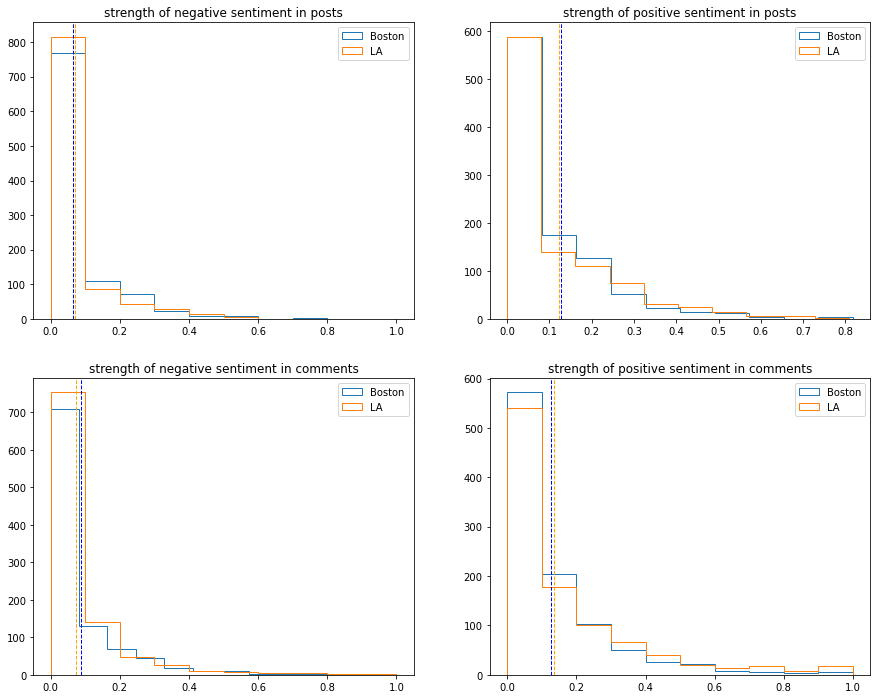

In [296]:
plt.figure(figsize = (15,12))
plt.subplot(2,2,1)
plt.title('strength of negative sentiment in posts')
plt.hist(BOS_posts_df['sia_neg'], histtype = 'step', label = 'Boston')
plt.hist(LA_posts_df['sia_neg'], histtype = 'step', label = 'LA')
plt.axvline(sia.polarity_scores(BOS_posts_corpus)['neg'], ls = '--', lw = 1, color = 'blue')
plt.axvline(sia.polarity_scores(LA_posts_corpus)['neg'], ls = '--', lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,2)
plt.title('strength of positive sentiment in posts')
plt.hist(BOS_posts_df['sia_pos'], histtype = 'step', label = 'Boston')
plt.hist(LA_posts_df['sia_pos'], histtype = 'step',label = 'LA')
plt.axvline(sia.polarity_scores(BOS_posts_corpus)['pos'], ls = '--', lw = 1,  color = 'blue')
plt.axvline(sia.polarity_scores(LA_posts_corpus)['pos'], ls = '--',lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,3)
plt.title('strength of negative sentiment in comments')
plt.hist(BOS_comments_df['sia_neg'], histtype = 'step', label = 'Boston')
plt.hist(LA_comments_df['sia_neg'], histtype = 'step', label = 'LA')
plt.axvline(sia.polarity_scores(BOS_comments_corpus)['neg'], ls = '--', lw = 1, color = 'blue')
plt.axvline(sia.polarity_scores(LA_comments_corpus)['neg'], ls = '--', lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,4)
plt.title('strength of positive sentiment in comments')
plt.hist(BOS_comments_df['sia_pos'], histtype = 'step', label = 'Boston')
plt.hist(LA_comments_df['sia_pos'], histtype = 'step',label = 'LA')
plt.axvline(sia.polarity_scores(BOS_comments_corpus)['pos'], ls = '--', lw = 1,  color = 'blue')
plt.axvline(sia.polarity_scores(LA_comments_corpus)['pos'], ls = '--',lw = 1, color = 'orange')
plt.legend();

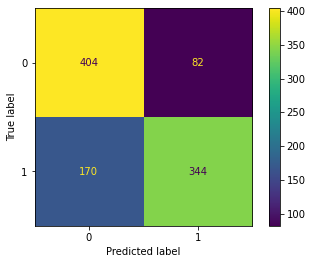

In [395]:
plot_confusion_matrix(mnb, test_X_vec, test_y);

In [397]:
X.iloc[[i for i in range(len(mnb.predict(test_X_vec))) if mnb.predict(test_X_vec[i]) == 1 and test_y[i] ==0]]

12                              Pru prepared for 2020 😍
28    PLACEerner moving to PPLACECE - Driving advice...
37    Anyone using an app that tracks MBTA busses in...
38    Trombone guy at PLACE CenterThere's a guy play...
40    Potential PPLACECE Job Offer - Move from PPLAC...
                            ...                        
52          How long does it take to brush your car off
55    I moves here from England just under two years...
59    Ban on sale of vaping products ends today (Dec...
60    PPLACECE Embraces ‘People-First’ Design For PL...
79    Any experience with PLACEhealth plans?I was ju...
Length: 82, dtype: object

In [394]:
BOS_comments_df.to_csv('bos_com.csv')
BOS_posts_df.to_csv('bos_pos.csv')
LA_comments_df.to_csv('la_com.csv')
LA_posts_df.to_csv('la_pos.csv')